In [1]:
import numpy as np
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_dataset
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
# Model and tokenizer
model_name = 'siebert/sentiment-roberta-large-english'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, output_hidden_states=True)
model.eval()
model.to('cuda')

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-23): 24 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
 

In [12]:
# Load the dataset
dataset = load_dataset('go_emotions')

# Select a subset of 2000 samples from the 'train' split
subset_size = 2000
data = dataset['train'].shuffle(seed=42)#.select(range(subset_size))

In [13]:
# Extract texts and labels
texts = data['text']
labels = data['labels']  # Multi-labels (list of lists)

In [14]:
# Simplify labels to the first label
single_labels = [label[0] if label else -1 for label in labels]

# Filter out samples without labels
filtered_texts = [text for text, label in zip(texts, single_labels) if label != -1]
filtered_labels = [label for label in single_labels if label != -1]

print(f"Number of samples after filtering: {len(filtered_texts)}")

Number of samples after filtering: 43410


In [9]:
filtered_texts

['I would say they do because it was a horrible accident but they were also in the wrong. The military tried to get them to disperse they didnt.',
 'Done, good luck with your thing.',
 'Now, this is epic! ',
 'Eat better.',
 'So you stay on your theft from auto waiting for them to dispatch the next shift to the backlog of calls.',
 "Glad to hear it's ubiquitous and not an OS thing.",
 'Now we’re wishing death on 15 year old kids? Keep setting the bar lower please',
 'Oh so it is a separate guy filming, it’s actually impressive how synced up their speeds are',
 "Yes. I got accused of being a man or a bootlicker because I was a mod in a men's lib sub two years ago.",
 'Get big, whatever it takes.',
 'It’s amazing what they can justify to themselves. I’m not sure if I can believe anything out of her mouth anymore.',
 "Calm down. It's a real concept.",
 'Wow, what a controversial opinion.',
 "If I have to watch Canada lose in a shootout I'm gonna lose it",
 'what time is it now? i’m defini

In [11]:
def get_embeddings(text_list, tokenizer, model):
    embeddings = []
    batch_size = 16 
    check = batch_size*50
    with torch.no_grad():
        for i in range(0, len(text_list), batch_size):
            batch_texts = text_list[i:i+batch_size]
            inputs = tokenizer(batch_texts, padding=True, truncation=True, return_tensors='pt', max_length=128)
            inputs = inputs.to('cuda')
            outputs = model(**inputs, output_hidden_states=True)

            hidden_states = outputs.hidden_states  # Tuple of tensors

            embe = []
            for last_hidden_state in hidden_states:
                # Mean pooling
                attention_mask = inputs['attention_mask'].unsqueeze(-1)  # Shape: (batch_size, seq_length, 1)
                masked_hidden_state = last_hidden_state * attention_mask
                sum_embeddings = torch.sum(masked_hidden_state, dim=1)
                sum_mask = torch.sum(attention_mask, dim=1)
                embedding = sum_embeddings / sum_mask  # Shape: (batch_size, hidden_size)
                embe.append(embedding.unsqueeze(0))
            embedding = torch.cat(embe, dim=0)
            embeddings.append(embedding)
            
            if i % check == 0:
                print(f"Processed {i + len(batch_texts)}/{len(text_list)} samples")
    embeddings = torch.cat(embeddings, dim=1)
    return embeddings


In [12]:
embeddings = get_embeddings(filtered_texts, tokenizer, model)
print(f"Embeddings shape: {embeddings.shape}")

Processed 16/43410 samples
Processed 816/43410 samples
Processed 1616/43410 samples
Processed 2416/43410 samples
Processed 3216/43410 samples
Processed 4016/43410 samples
Processed 4816/43410 samples
Processed 5616/43410 samples
Processed 6416/43410 samples
Processed 7216/43410 samples
Processed 8016/43410 samples
Processed 8816/43410 samples
Processed 9616/43410 samples
Processed 10416/43410 samples
Processed 11216/43410 samples
Processed 12016/43410 samples
Processed 12816/43410 samples
Processed 13616/43410 samples
Processed 14416/43410 samples
Processed 15216/43410 samples
Processed 16016/43410 samples
Processed 16816/43410 samples
Processed 17616/43410 samples
Processed 18416/43410 samples
Processed 19216/43410 samples
Processed 20016/43410 samples
Processed 20816/43410 samples
Processed 21616/43410 samples
Processed 22416/43410 samples
Processed 23216/43410 samples
Processed 24016/43410 samples
Processed 24816/43410 samples
Processed 25616/43410 samples
Processed 26416/43410 samp

In [22]:
embeddings_np.shape

(25, 43410, 1024)

In [18]:
embeddings_normed = embeddings/torch.norm(embeddings, dim = 2, keepdim=True)
embeddings_np = embeddings_normed.cpu().numpy()

In [19]:
embeddings = embeddings.cpu()
embe = embeddings.numpy()
mean_vector = np.mean(embe, axis=0)
embeddings_centered = embe - mean_vector

In [7]:
# save the embeddings
# np.save('embeddings_full_alllayers.npy', embeddings_np)
embeddings_np = np.load('embeddings_full_alllayers.npy')
# np.save('embeddings_centered_full_alllayers.npy', embeddings_centered)
# embeddings_centered = np.load('embeddings_centered_full.npy')

In [8]:
embeddings_np[-1,].shape, embeddings_np[-1,]

((43410, 1024),
 array([[ 0.01253039,  0.01960429, -0.01120528, ...,  0.02586794,
         -0.03161669,  0.02663904],
        [-0.0011519 , -0.00469375, -0.0175989 , ...,  0.00348454,
         -0.00132908, -0.00027473],
        [-0.00072273, -0.00485301, -0.01794095, ...,  0.00385063,
         -0.00326701,  0.00238087],
        ...,
        [ 0.0005035 ,  0.01817568, -0.00814134, ...,  0.02066889,
         -0.0360621 ,  0.02576344],
        [-0.00178948, -0.00444298, -0.01753988, ...,  0.00377289,
          0.00342901, -0.00867185],
        [-0.01071027,  0.0157763 , -0.00320896, ...,  0.019621  ,
         -0.0280036 ,  0.01135622]], dtype=float32))

Here I guess we would need spherical PCA. Normalization and playning on Euclidean space doesn't bring anything so one really needs some factors over sphere?

In [9]:
from sklearn.decomposition import PCA

n_components = 5  # Number of components to keep
principal_components = []
for i in range(0, 25, 1):
    pca = PCA(n_components=n_components)
    principal_components.append(pca.fit_transform(embeddings_np[i, ]))

principal_components

[array([[-0.27200454, -0.08708458, -0.08369394, -0.06830572,  0.0787835 ],
        [ 0.17171599, -0.09909932,  0.01392093, -0.03631894, -0.06509799],
        [ 0.25058818, -0.05366797, -0.02129906, -0.05806734, -0.07048896],
        ...,
        [ 0.05481782, -0.05309921,  0.02546246,  0.01182417, -0.22605708],
        [ 0.12006981, -0.04720117,  0.02576494,  0.02318807, -0.05059424],
        [-0.20067108, -0.05831527,  0.00388315, -0.01951708, -0.02363561]],
       dtype=float32),
 array([[-0.12370171, -0.02486406,  0.00778035, -0.02437837,  0.01150462],
        [ 0.07844452, -0.0437779 , -0.03711741, -0.02069982, -0.00815625],
        [ 0.14805864, -0.01715845,  0.02420373, -0.0671418 , -0.00072065],
        ...,
        [ 0.03116321, -0.05003418, -0.00845023,  0.03006664,  0.03178316],
        [ 0.10967328, -0.02213049,  0.07490432, -0.04550188, -0.00060401],
        [-0.10231959, -0.0491334 , -0.00956113, -0.00764113, -0.01906985]],
       dtype=float32),
 array([[-0.13864586, -0.0

In [63]:
#explained_variance = pca.explained_variance_ratio_
#for i, var in enumerate(explained_variance):
#    print(f'PC{i+1} explains {var*100:.2f}% of the variance')

PC1 explains 58.35% of the variance
PC2 explains 19.94% of the variance
PC3 explains 9.29% of the variance
PC4 explains 6.22% of the variance
PC5 explains 1.48% of the variance
PC6 explains 1.28% of the variance
PC7 explains 0.31% of the variance
PC8 explains 0.21% of the variance
PC9 explains 0.14% of the variance


In [15]:
# Create a DataFrame
pc_columns = [f'HU{j+1} PC{i+1}' for j in range(25) for i in range(n_components) ]
pc_df = pd.DataFrame(np.concatenate(principal_components, axis = 1), columns=pc_columns)
pc_df['Emotion_Label'] = filtered_labels

# Get emotion names from the dataset
emotion_names = dataset['train'].features['labels'].feature.names

# Map labels to names
pc_df['Emotion_Name'] = pc_df['Emotion_Label'].apply(lambda x: emotion_names[x])


In [16]:
pc_df

,HU1 PC1,HU1 PC2,HU1 PC3,HU1 PC4,HU1 PC5,HU2 PC1,HU2 PC2,HU2 PC3,HU2 PC4,HU2 PC5,...,HU24 PC3,HU24 PC4,HU24 PC5,HU25 PC1,HU25 PC2,HU25 PC3,HU25 PC4,HU25 PC5,Emotion_Label,Emotion_Name
0,-0.272005,-0.087085,-0.083694,-0.068306,0.078784,-0.123702,-0.024864,0.007780,-0.024378,0.011505,...,0.087067,0.064131,0.002542,-0.801524,-0.273773,-0.024299,0.016554,0.008272,9,disappointment
1,0.171716,-0.099099,0.013921,-0.036319,-0.065098,0.078445,-0.043778,-0.037117,-0.020700,-0.008156,...,-0.142820,-0.022311,0.000565,0.994602,0.054766,-0.095483,0.012163,-0.000300,5,caring
2,0.250588,-0.053668,-0.021299,-0.058067,-0.070489,0.148059,-0.017158,0.024204,-0.067142,-0.000721,...,-0.069516,-0.049032,-0.019561,0.998146,0.037308,-0.057398,0.001838,-0.012186,27,neutral
3,0.439811,-0.016349,-0.183906,-0.051834,-0.031745,0.178119,-0.071639,-0.075136,0.013204,0.039466,...,-0.106486,-0.035079,-0.006847,0.996689,0.045445,-0.076894,0.007127,-0.007009,5,caring
4,-0.226735,-0.096719,-0.004919,-0.089566,-0.050301,-0.089728,-0.040854,-0.022175,0.001586,0.000224,...,0.109768,0.137810,-0.049299,-0.760084,-0.377064,-0.029578,0.054802,-0.015413,3,annoyance
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43405,0.310543,0.267610,0.156102,-0.125169,0.139004,0.099461,0.205295,-0.102755,-0.032007,-0.072194,...,0.242269,0.311565,0.225739,-0.596259,0.538447,0.223326,0.242750,0.022811,27,neutral
43406,0.291251,-0.111178,-0.014165,-0.083075,0.159594,0.169250,0.061441,0.095285,0.097684,-0.109049,...,-0.208067,-0.094360,-0.147342,-0.835186,0.236069,0.004773,-0.076099,0.007281,2,anger
43407,0.054818,-0.053099,0.025462,0.011824,-0.226057,0.031163,-0.050034,-0.008450,0.030067,0.031783,...,-0.084368,-0.279415,0.073427,-0.853139,0.082578,-0.016391,-0.085944,0.052460,25,sadness
43408,0.120070,-0.047201,0.025765,0.023188,-0.050594,0.109673,-0.022130,0.074904,-0.045502,-0.000604,...,-0.328822,0.062268,0.047093,0.978381,0.078391,-0.207770,0.032573,0.033235,0,admiration


In [17]:
# Calculate the mean of principal components for each emotion
mean_pcs = pc_df.groupby('Emotion_Name')[pc_columns].mean()


In [18]:
mean_pcs

,HU1 PC1,HU1 PC2,HU1 PC3,HU1 PC4,HU1 PC5,HU2 PC1,HU2 PC2,HU2 PC3,HU2 PC4,HU2 PC5,...,HU24 PC1,HU24 PC2,HU24 PC3,HU24 PC4,HU24 PC5,HU25 PC1,HU25 PC2,HU25 PC3,HU25 PC4,HU25 PC5
Emotion_Name,,,,,,,,,,,,,,,,,,,,,
admiration,0.035608,-0.000614,-0.008996,-0.009531,-0.023006,0.026614,-0.006533,0.013255,-0.013093,0.012308,...,0.625152,-0.093920,-0.137912,0.009157,0.013503,0.776440,0.049981,-0.089951,0.011845,0.007893
amusement,0.009365,0.009671,-0.006001,0.019172,0.002194,0.016950,0.010897,0.039929,0.007252,-0.002658,...,0.196984,0.027978,0.021396,-0.015604,-0.002916,0.238498,0.019150,0.015141,-0.004320,-0.004840
anger,0.040884,0.018174,-0.008000,-0.010097,-0.002073,0.021902,0.016703,0.007343,0.043290,-0.016992,...,-0.521646,-0.075931,0.035384,0.013565,-0.007772,-0.615703,-0.089443,0.007216,0.001743,-0.000580
annoyance,-0.038865,-0.007272,-0.000974,-0.000111,0.001733,-0.016784,-0.002742,0.001865,0.028503,-0.013571,...,-0.512444,-0.125841,0.045780,0.028477,-0.008425,-0.599315,-0.120619,0.002268,0.009199,-0.002932
approval,-0.040248,-0.013498,-0.001664,0.006175,-0.000653,-0.020764,-0.009843,-0.006556,-0.005225,-0.002194,...,0.193484,0.065013,0.034069,-0.013409,-0.002804,0.226863,0.031132,0.028806,-0.004627,-0.004061
caring,-0.036558,-0.023582,-0.005539,0.002186,0.016055,-0.015391,-0.018218,0.004250,-0.017451,0.001032,...,0.218496,0.040849,-0.004950,-0.001146,0.003617,0.259922,0.035889,0.004845,-0.000059,0.000036
confusion,-0.050417,-0.004221,0.010595,0.000889,0.032498,-0.028303,0.002070,-0.008706,0.001287,-0.022718,...,-0.397490,0.014581,0.037290,0.009794,-0.006079,-0.499793,-0.033188,0.022396,0.000325,-0.002558
curiosity,-0.014056,-0.002185,0.020125,-0.010369,0.021827,-0.009185,0.006935,-0.010409,0.001443,-0.022270,...,-0.213228,0.108791,0.048715,-0.000526,0.003919,-0.290115,0.028104,0.044114,-0.004280,-0.003567
desire,-0.054349,-0.007669,0.017386,0.005024,0.023224,-0.029065,-0.003335,0.004429,-0.019307,0.004327,...,0.238499,0.037918,0.031544,-0.017356,-0.003168,0.282214,0.028793,0.021543,-0.002966,-0.005332


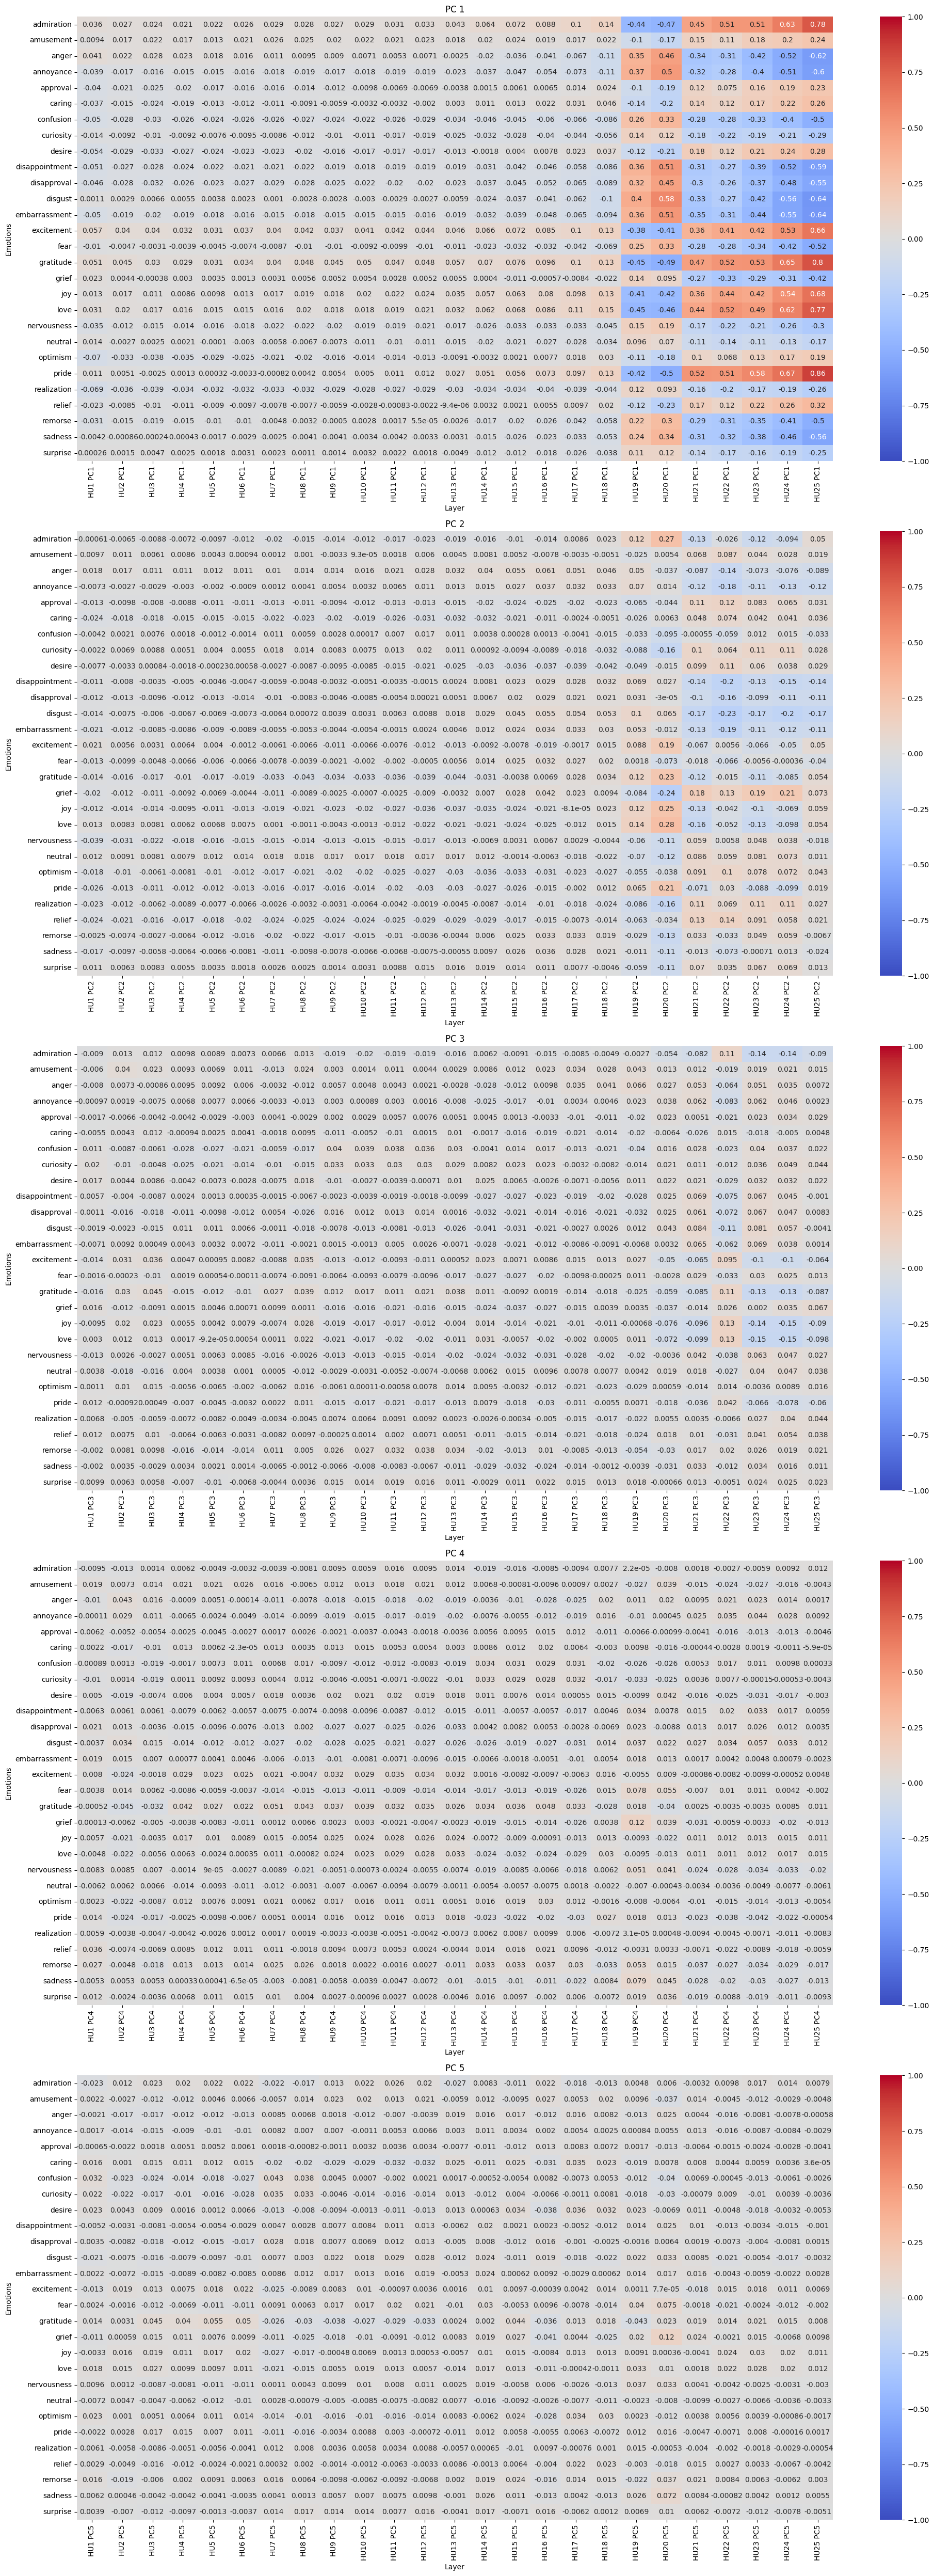

In [21]:
n_subplots = 5
fig, axes = plt.subplots(n_subplots, 1, figsize=(20, 50))

for i in range(n_subplots):
    component_indices = np.arange(0, 25*n_components, 5) + i
    data = mean_pcs.iloc[:, component_indices]
    sns.heatmap(data, cmap='coolwarm', annot=True, ax=axes[i], vmin= -1, vmax=1)
    axes[i].set_title(f'PC {i+1}')
    axes[i].set_xlabel('Layer')
    axes[i].set_ylabel('Emotions')

plt.tight_layout()
plt.show()
